# Time Domain data analysis pt.2

# Data loading

(100, 3)


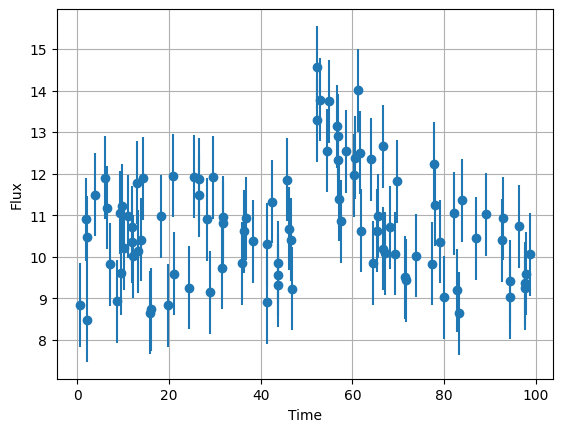

In [1]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")
print(data.shape)

time, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time, flux, yerr=err, fmt='o')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.grid()
plt.show()

## Nested Sampling

The basic idea of Nested Sampling is to transform the multi-dimensional evidence integral into a one-dimensional integral over the prior volume. 
We start with the definition of the Bayesian evidence, $\mathcal{Z}$:
$$
\mathcal{Z} = \int\, d^m\theta\, p(d|\theta)p(\theta) = \int\, d^m\theta\, \mathcal{L}(\theta)\pi(\theta) 
$$
where $p(d|\theta)=\mathcal{L}(\theta)$ is the likelihood, $p(\theta)=\pi(\theta)$ is the prior, and $m$ is the number of model parameters.
We can also define the prior volume, $X(\lambda)$, as
$$
X(\lambda) = \int_{\mathcal{L}>\lambda}\, d^m\theta\, \pi(\theta)
$$
where the integral is over the model parameter region that exceeds the likelihood contour $\mathcal{L}(\theta)=\lambda$, so $\lambda$ is a likelihood threshold.
The prior volume is a monotonically decreasing function of $\lambda$, with $X(0)=1$ and $X(\infty)=0$.

So we can transform the evidence integral into
$$
\mathcal{Z} = \int_0^1\, dX\, \mathcal{L}(X)
$$

The algorithm follows these steps:
- We start with $N$ "live points" sampled on the prior volume.
- We find the point with the lowest likelihood, $\mathcal{L}_{min}$, and remove it from the set of live points.
- We replace it with a new point, but this time sampled from the prior volume with the constraint: $\mathcal{L}>\mathcal{L}_{min}$.
- We repeat the process, each time removing the lowest likelihood point and replacing it with a new point sampled from the constrained prior volume, untill the evidence is sufficiently converged.
- At each iteration, we can estimate the contribution to the evidence from the removed point as $w_i\mathcal{L}_i$, where $w_i$ is the weight associated with the prior volume shrinkage. 
$$
\mathcal{Z} = \mathcal{Z} + w_i\mathcal{L}_i \hspace{1cm} w_i = (X_{i-1}-X_{i}) \hspace{1cm} X_i = e^{-i/N}
$$

In [ ]:
def brust_model(t, theta):
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))

def gaussian_model(t, theta):
    b, A, t0, sigmaW = theta
    return b + A * np.exp(-0.5 * (t - t0) ** 2 / (2 * sigmaW ** 2))

b_min, b_max = 0, 50
A_min, A_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)
sigmaW_min, sigmaW_max =  np.exp(-2), np.exp(2)
ndim = 4

def log_likelihood(theta, x, y, y_err, model):
    y_fit = model(x, theta)
    chi2 = np.sum(((y - y_fit) / y_err) ** 2)
    return  -0.5 * chi2

# Define our uniform prior.
# At the beggining we sample from a hypercube [0,1]^ndim
def ptform(u, model):
    # we use a uniform prior trasformation for b, A, t0 and a log-uniform prior trasformation for alpha or sigmaW
    b = b_min + u[0] * (b_max - b_min)
    A = A_min + u[1] * (A_max - A_min)
    t0 = t0_min + u[2] * (t0_max - t0_min)
    if model == brust_model:
        alpha = alpha_min * (alpha_max / alpha_min) ** u[3]
        return np.array([b, A, t0, alpha])
    elif model == gaussian_model:
        sigmaW = sigmaW_min * (sigmaW_max / sigmaW_min) ** u[3]
        return np.array([b, A, t0, sigmaW])
    else:
        raise ValueError("Unknown model")
    

In [3]:
import dynesty

sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, err, brust_model], ptform_args=[brust_model], nlive=500)
sampler.run_nested()
sresults_brust_model = sampler.results

/tmp/ipykernel_26018/1641933880.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
/tmp/ipykernel_26018/1641933880.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
1795it [00:01, 966.37it/s, bound: 0 | nc: 32 | ncall: 16019 | eff(%): 11.205 | loglstar:   -inf < -192.107 <    inf | logz: -200.823 +/-  0.126 | dlogz: 110.504 >  0.509] /tmp/ipykernel_26018/1641933880.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
/tmp/ipykernel_26018/1641933880.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
1909it [00:02, 462.32it/s, bound: 1 | nc: 56 | ncall: 19481 | eff(%):  9.799 | loglstar:   -inf < -161.080 <    inf | logz: -170.015 +/-  0.123 | dlogz: 106.334 >  0.509]/tmp/ipykernel_26018/1641933880.py:3: RuntimeWarning: overflow en

Remind that when we use the Nested Sampling we can't stop the algorithm when we want, because we need to be sure that the evidence is converged.

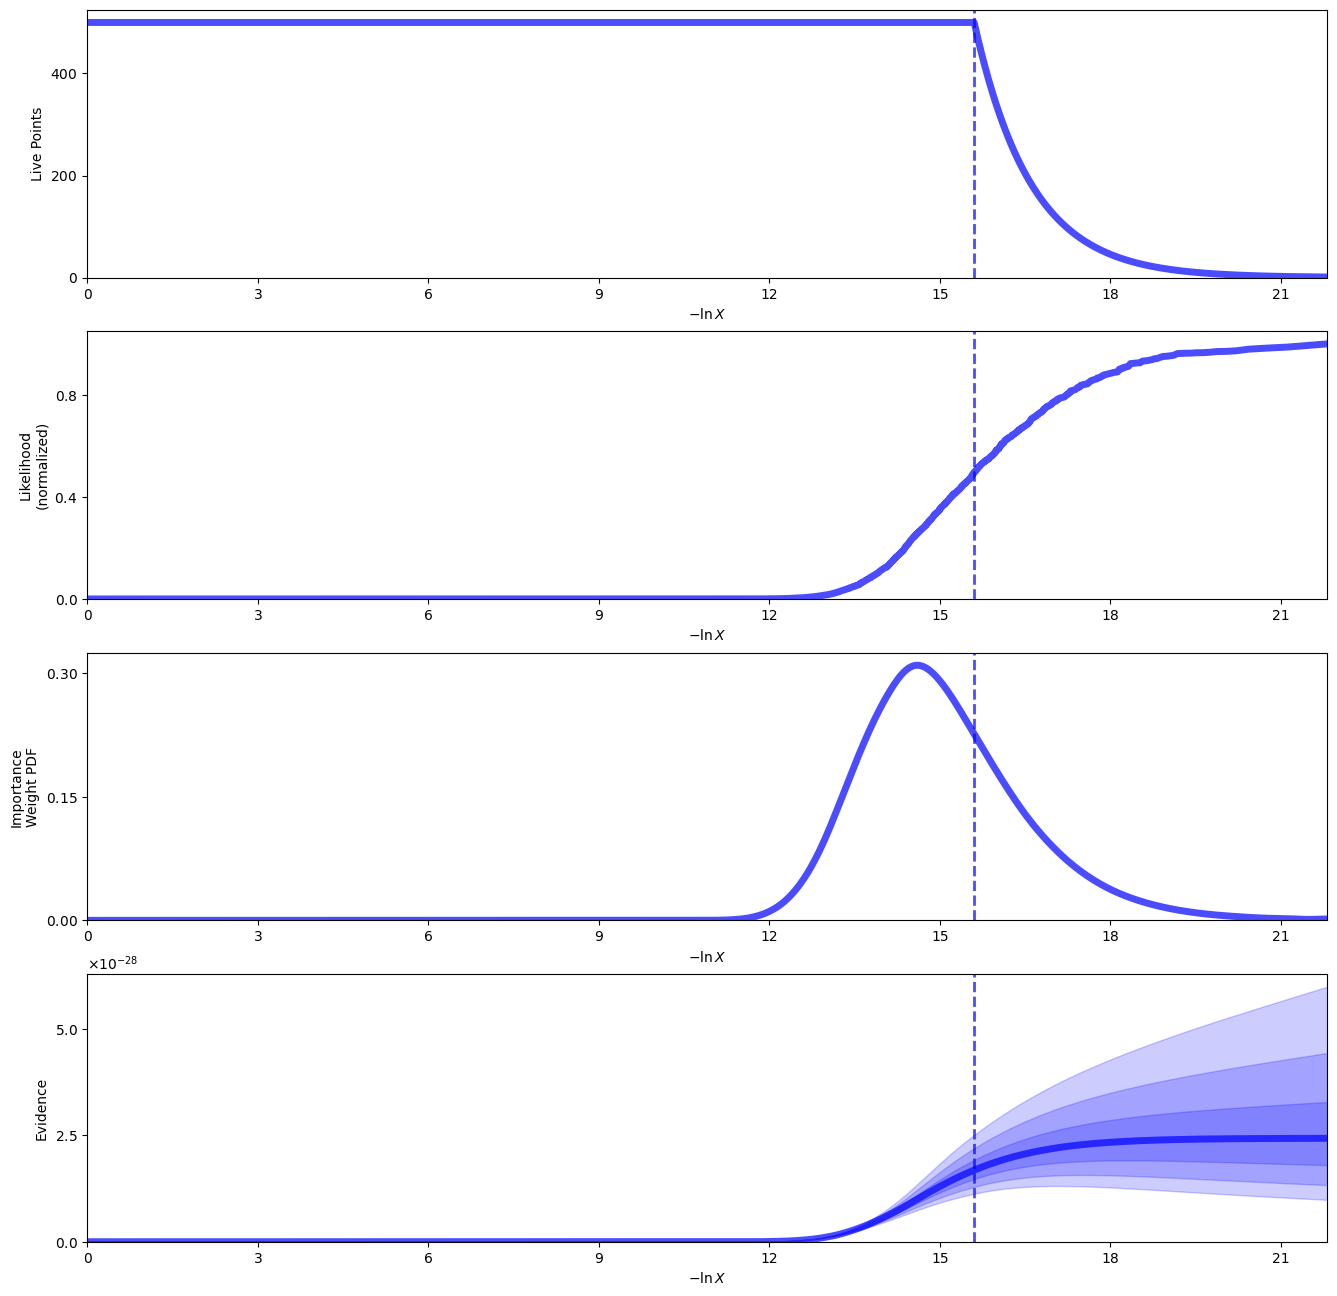

In [4]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(sresults_brust_model)

In these four lines we can see how the algorithm work: 
- (Line 1) The number of **Live Points** is the same until the nested sampling is stopped.
- (Line 2) The value of the likelihood trehold increase monotonously, while $X$ decrease (in the Figure there is the $-\ln(X)$).
- (Line 3) The region with higher weight for the estimate of the posterior distribution is the one just before the algorithm is stopped, where the likelihood and the prior volume are balanced. At the beginning the likelihood is very low and the prior volume is very high, at the end the likelihood is very high but the prior volume is very low.
- (Line 4) The evidence increase monotonously, following the equation: $\mathcal{Z} = \mathcal{Z} + w_i\mathcal{L}_i$

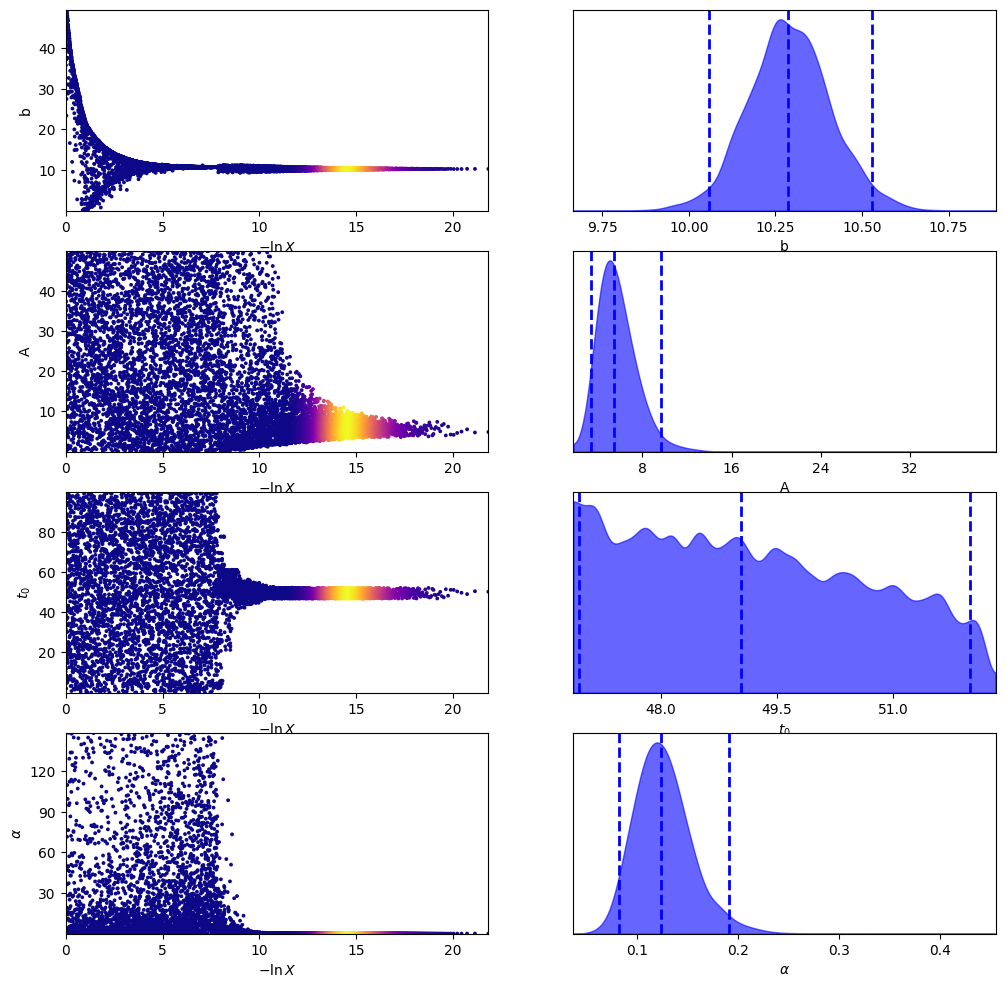

In [5]:
rfig, raxes = dyplot.traceplot(sresults_brust_model, labels=["b", "A", r"$t_0$", r"$\alpha$"])

The `dynesty.NestedSampler` function return not only the samples, but also the weights, $w_i$. 
In some case we need to use uniform weights, for example when we want to use the `corner` package to plot the posterior distribution. To do this we can use the `resample_equal` function from `dynesty.utils`.

In [6]:
from dynesty import utils as dyfunc

samples = sresults_brust_model.samples  # samples
weights = np.exp(sresults_brust_model.logwt - sresults_brust_model.logz[-1])  # normalized weights
samples_equal = dyfunc.resample_equal(samples, weights)

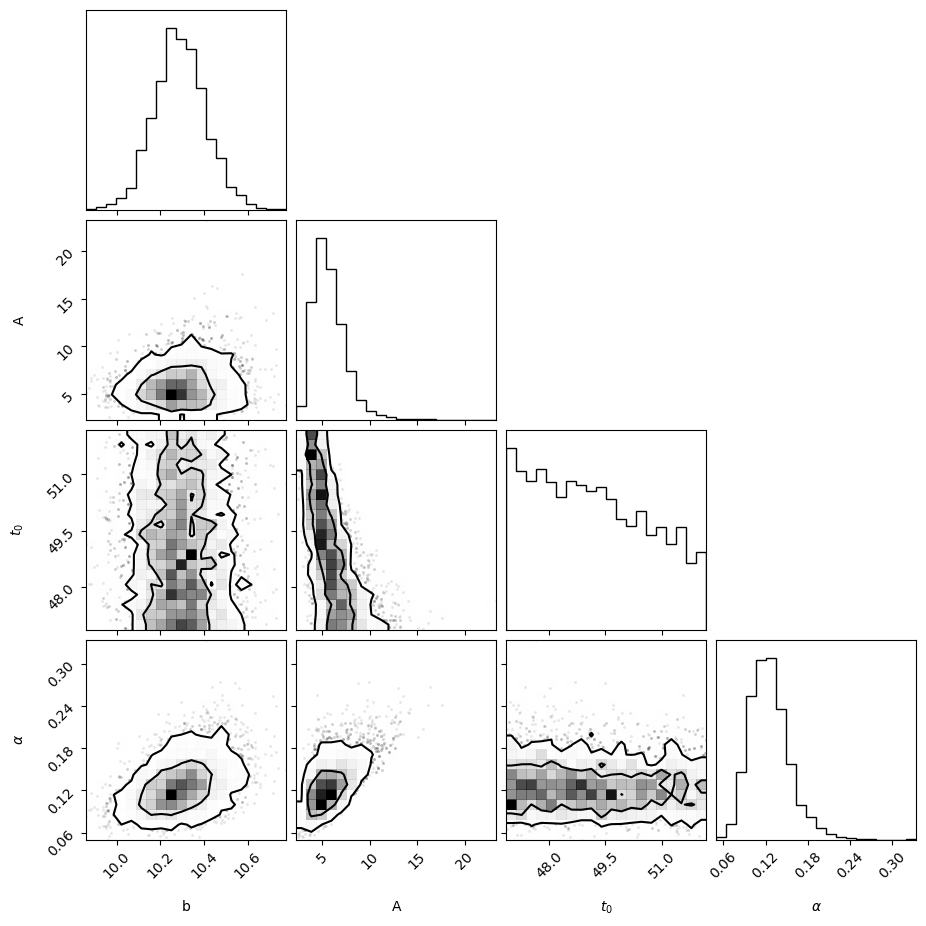

In [7]:
import corner

corner.corner(samples_equal, labels=["b", "A", r"$t_0$", r"$\alpha$"], levels=[0.68, 0.95]);

In [8]:
evidence_brust_model = sresults_brust_model.logz[-1]
sresults_brust_model.summary()

Summary
nlive: 500
niter: 7809
ncall: 135268
eff(%):  6.143
logz: -63.585 +/-  0.301


Now we can try to use a different model.

In [9]:
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, err, gaussian_model], ptform_args=[gaussian_model], nlive=500)
sampler.run_nested()
sresults_gaussian_model = sampler.results

4028it [00:25, 14.07it/s, bound: 62 | nc: 86 | ncall: 64033 | eff(%):  6.291 | loglstar:   -inf < -86.635 <    inf | logz: -94.921 +/-  0.120 | dlogz: 30.581 >  0.509]       /mnt/c/Users/User/Desktop/info/myenv/lib/python3.11/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4833it [00:39, 119.46it/s, bound: 89 | nc: 18 | ncall: 84635 | eff(%):  5.710 | loglstar:   -inf < -74.111 <    inf | logz: -85.713 +/-  0.144 | dlogz: 23.396 >  0.509] /mnt/c/Users/User/Desktop/info/myenv/lib/python3.11/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined fro

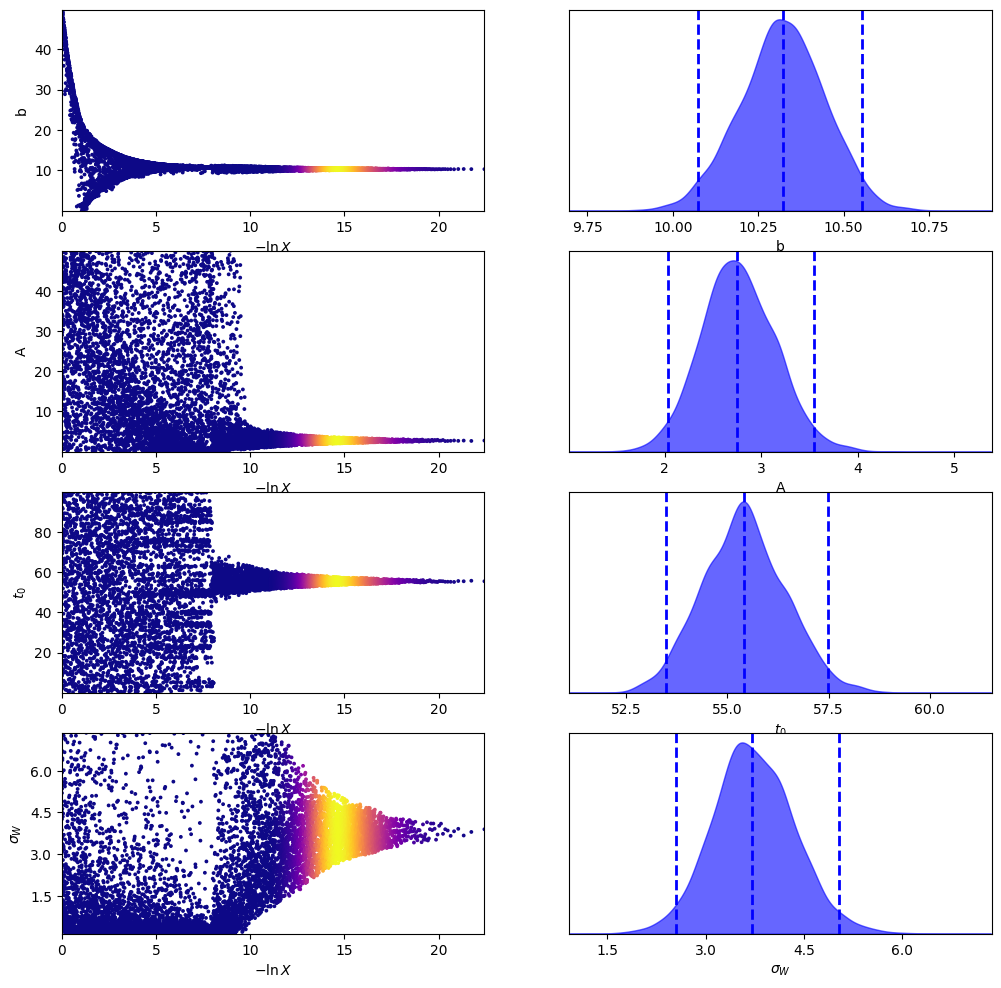

In [10]:
rfig, raxes = dyplot.traceplot(sresults_gaussian_model, labels=["b", "A", r"$t_0$", r"$\sigma_W$"])

In [11]:
samples = sresults_gaussian_model.samples  # samples
weights = np.exp(sresults_gaussian_model.logwt - sresults_gaussian_model.logz[-1])  # normalized weights
samples_equal = dyfunc.resample_equal(samples, weights)

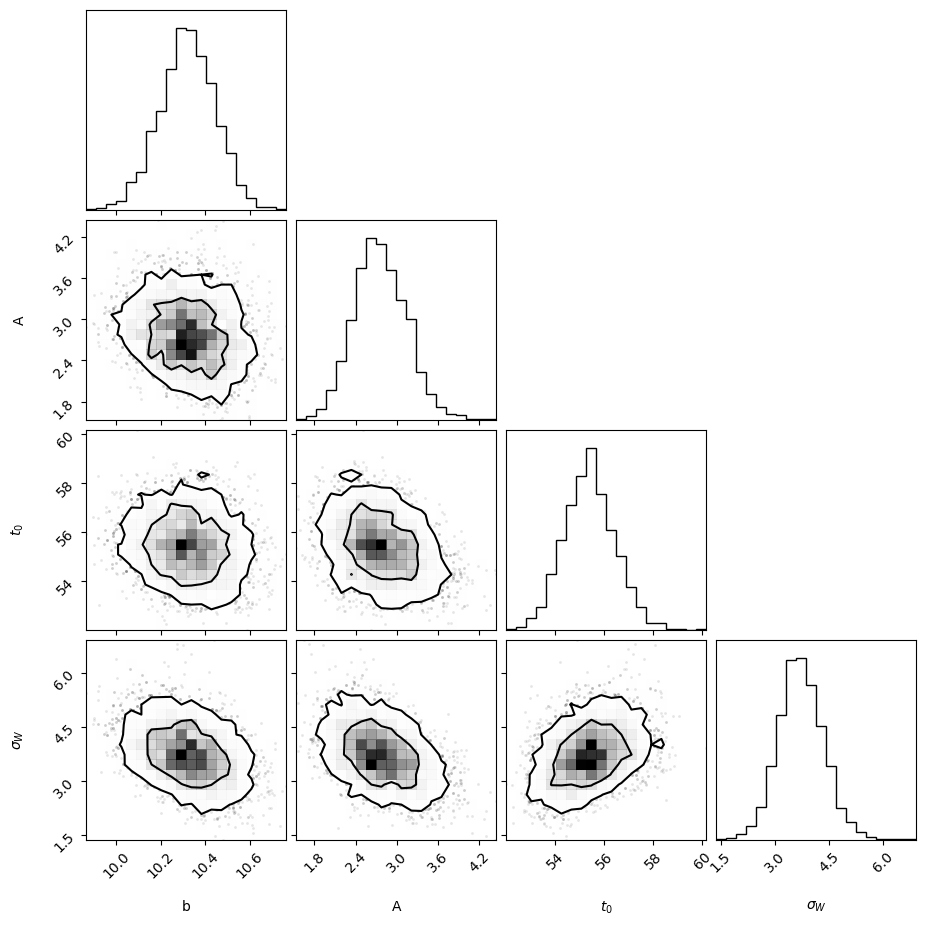

In [12]:
corner.corner(samples_equal, labels=["b", "A", r"$t_0$", r"$\sigma_W$"], levels=[0.68, 0.95]);

In [13]:
evidence_gaussian_model = sresults_gaussian_model.logz[-1]
sresults_gaussian_model.summary()

Summary
nlive: 500
niter: 8110
ncall: 98431
eff(%):  8.747
logz: -67.939 +/-  0.303


## Model comparison

To compare two different models we can use the Bayes theorem:
$$
p(M_i|d) = \frac{p(d|M_i)p(M_i)}{p(d)}
$$
so the ratio of the posterior probabilities of two models is
$$
O_{21}=\frac{p(M_1|d)}{p(M_2|d)} =\underbrace{\frac{p(d|M_1)}{p(d|M_2)}}_{B_{21}} \frac{p(M_1)}{p(M_2)}
$$
where $B_{21}$ is the Bayes factor, the ratio of the evidences of the two models.

If the prior probabilities of the two models are equal, as in our case, the ratio of the posterior probabilities is equal to the Bayes factor.
$$
O_{21}=B_{21}
$$

The Bayes factor can be interpreted as follows:

<div style="text-align: center;">
    <img src="BayesFactor.png" alt="Bayes Factor" width="500" height="300">
</div>

In [14]:
B = evidence_gaussian_model / evidence_brust_model
print("Bayes factor (Gaussian vs. Brust): ", B)

Bayes factor (Gaussian vs. Brust):  1.0684706359845915


So there isn't a significant evidence to choose one model or the other.